在2014年的ImageNet图像识别挑战赛中，一个名叫*GoogLeNet* :cite:`Szegedy.Liu.Jia.ea.2015`的网络架构大放异彩。
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
毕竟，以前流行的网络使用小到$1 \times 1$，大到$11 \times 11$的卷积核。
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。
本节将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。
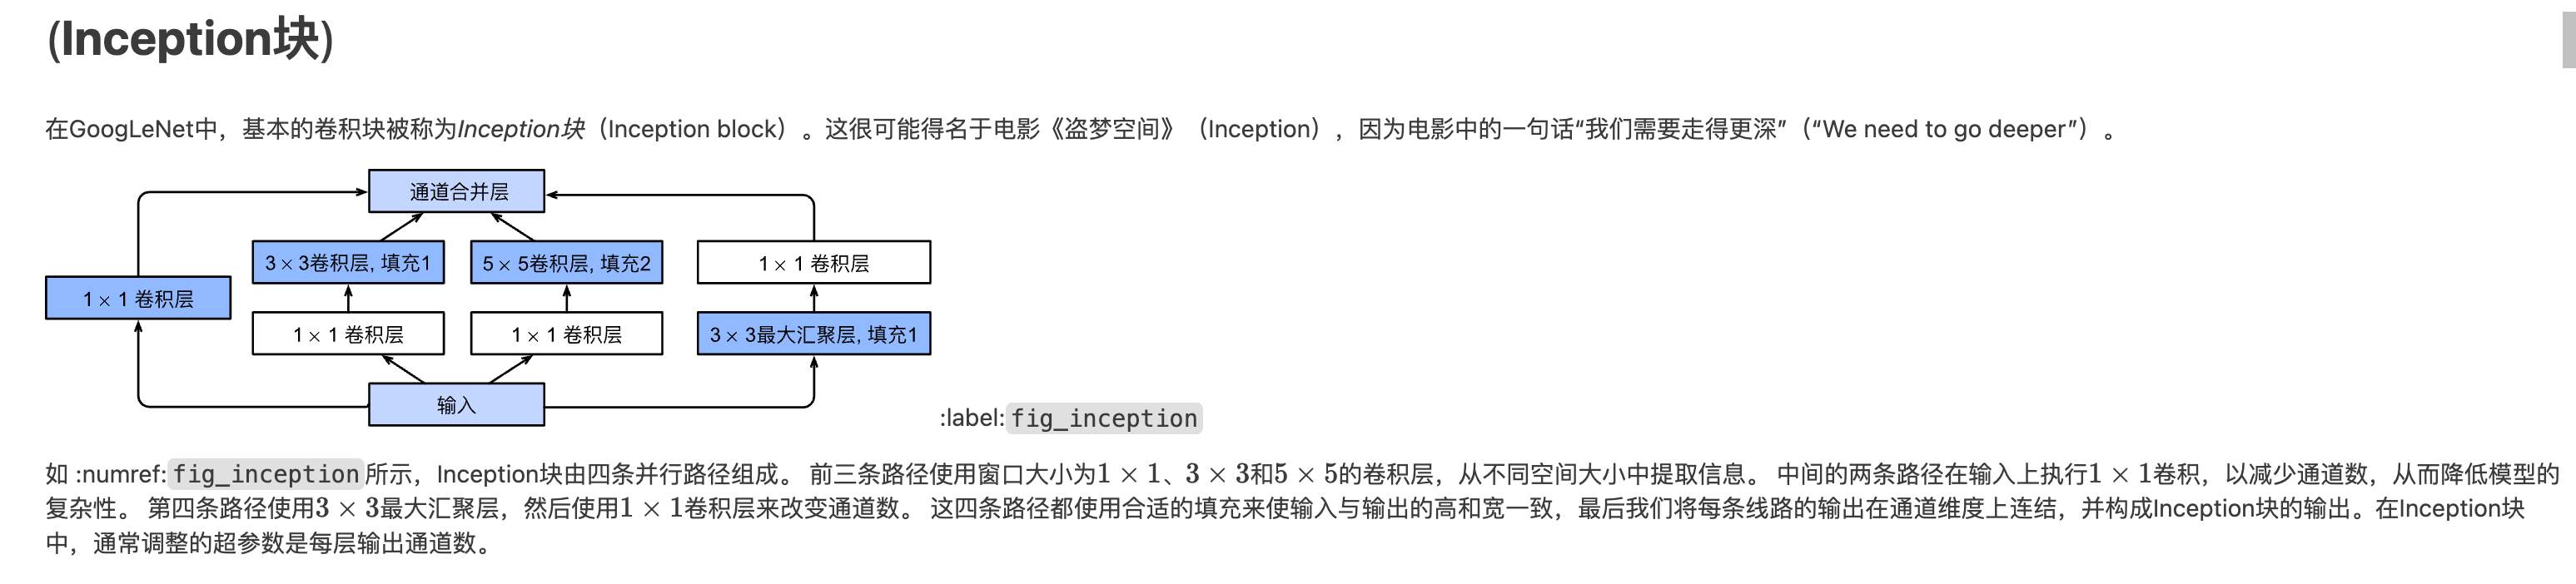

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [3]:
# 维度是这样的输入方式
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

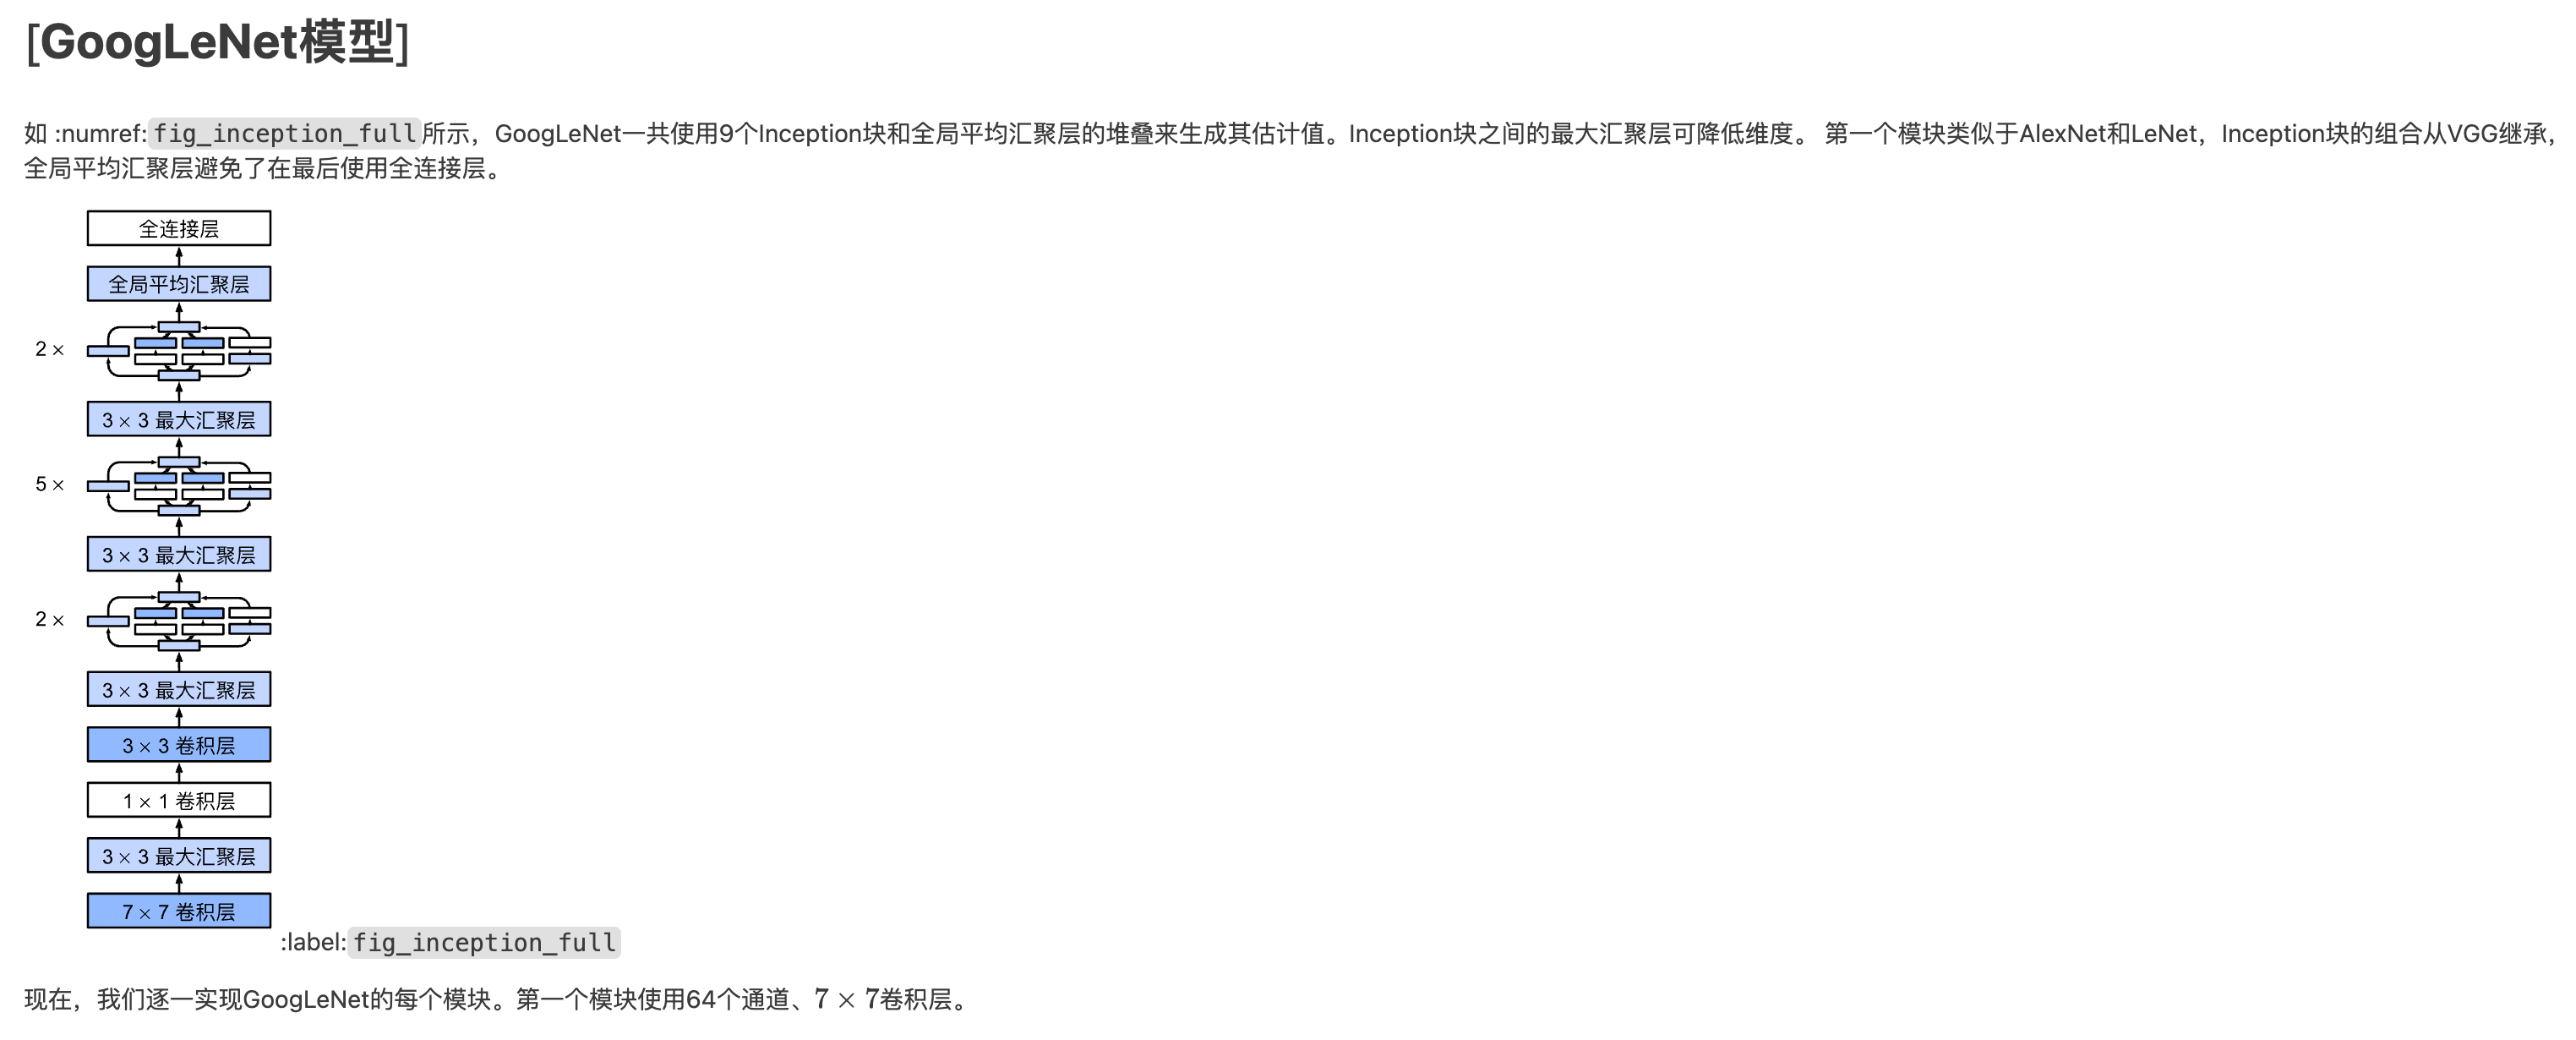

## 小结

* Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用$1×1$卷积层减少每像素级别上的通道维数从而降低模型复杂度。
*  GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。
* GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。
